<center><font color='steelblue'> <font size = "5,5">CORPORACIÓN UNIVERSITARIA MINUTO DE DIOS </font></center><br>
<center><font color='steelblue'> <font size = "5">FACULTAD DE INGENIERÍA</font></center><br>
<center><font color='steelblue'> <font size = "4">PROGRAMA INGENIERÍA DE SISTEMAS</font></center><br>
<center><font color='steelblue'> <font size = "3">CURSO BASES DE DATOS MASIVAS</font></center><br>
<center><font color="yellow" size = "4" face = "small fonts">Proyecto Modular - Mojo</font></center>

<center><font color="olive" size = "4" face = "small fonts">DATOS DE LOS PARTICIPANTES DEL GRUPO</font></center>

<font color="yellow" size = "4" face = "small fonts">NRC: 80132</font></center><br>
<font color="yellow" size = "4" face = "small fonts">Nombres: Laura Tatiana Bernal Yanquen, Daniel Yesid Casallas Páez</font></center><br>
<font color="yellow" size = "4" face = "small fonts">ID:857437</font></center><br>

<font color="yellow" size = "4" face = "small fonts">El taller retoma algunas de las instrucciones utilizadas a través del curso de Bases de Datos Masivas, tener en cuenta seguir los pasos requeridos.</font></center><br>

<font color="yellow" size = "4" face = "small fonts">Al Cargar los archivos dispuestos en la carpeta Poryecto final BDM se debe utilizar sentencias que no fijen el path, este debe se dinámico en caso de que se creen nuevos paquetes</font></center><br>

<font color="red" size = "4" face = "small fonts">El ejercicio consta de seguir el cuaderno y  realizar las tareas solicitadas, Utilizar y citar la documentación propia de cada una de las herramientas utilizadas para realizar el tratamiento a la data.</font></center><br>

<font color="yellow" size = "4" face = "small fonts">1. Configuración e importe de las librerias.</font></center><br>

In [9]:
# Esta extencion permite que jupyter detecte cambios externos y recargue sin tener que reiniciar VSC
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Importar la librearia os para poder interactuar el sistema donde se esta ejecutando los archivos
import os
import requests
import re
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import defaultdict
import json

<font color="yellow" size = "4" face = "small fonts">2. Configure y levante los contenedores necesarios para la actividad, recuerde que la arquitectura respeta a 3 contenedores con una distribucion de DBMongo en cada una de ellas, un contenedor que tiene configurado Mojolicious con todas sus dependencias junto con una base de datos Relacional la cual sera escogida a su gusto.</font></center><br>

In [ ]:
# Moverse a la carpeta data donde estan los archivos para lanzar el docker
os.chdir("../data")
# Crear y ejecutar el docker-compose.yml
os.system("docker-compose up --build")

<font color="yellow" size = "4" face = "small fonts">3. Una vez tenga el contenedor arriba cargue los datos .Json, uno por cada contenedor DBMongo.</font></center><br>

<font color="yellow" size = "4" face = "small fonts">Tenga en cuenta que debe tener la replica de los formatos `JSon` en cada contenedor</font></center><br>

In [5]:
# Con estos comandos se deben cargar los datos .json dentro de las mongoDB sin necesidad de una funcion.

# Comando para importar personas.json
os.system("docker cp ../data/personas.json core_container:/app/data/personas.json")

# Comando para importar articulos.json
os.system("docker cp ../data/articulos.json core_container:/app/data/articulos.json")

# Comando para importar ventas.json
os.system("docker cp ../data/ventas.json core_container:/app/data/ventas.json") 

0

<font color="yellow" size = "4" face = "small fonts">Se debe colocar el puerto expuesto del contenedor `Mojo`, para llamar la función y cargar los datos</font></center><br>

In [6]:
# Cargar data a las Mongo a con la funcion
requests.get("http://localhost:8080/load_data")

<Response [200]>

<font color="yellow" size = "4" face = "small fonts">4. Muestre los datos que fueron almacenados en cada una de las distribuciones de BDMongo.</font></center><br>

In [ ]:
# Verificar conteo de documentos en la colección personas
os.system("")

# Verificar conteo de documentos en la colección articulos
os.system("")

# Verificar conteo de documentos en la colección ventas
os.system("")

<font color="yellow" size = "4" face = "small fonts">Consultar a tráves del puerto expuesto la data que se encuentran en las colecciones personas, articulos y ventas de DBMongo</font></center><br>

In [ ]:
# Ver personas en MongoDB
personas = requests.get("http://localhost:8080/mongo/personas")
print(json.dumps(personas.json(), ensure_ascii=False, indent=2))

In [ ]:
# Ver articulos en MongoDB
articulos = requests.get("http://localhost:8080/mongo/articulos")
print(json.dumps(articulos.json(), ensure_ascii=False, indent=2))

In [ ]:
# Ver ventas en MongoDB
ventas = requests.get("http://localhost:8080/mongo/ventas")
print(json.dumps(ventas.json(), ensure_ascii=False, indent=2))

<font color="yellow" size = "4" face = "small fonts">5. Verifique la estructura y tipo de los datos almacenados en las distribuciones DBMongo, genere una ETL para almacenar cada una de las distribuciones en la base de datos Relacional que configuro con anterioridad, recuerde que cada distribucion debe ir en una tabla relacional respetando la integridad referencial.</font></center><br>

In [7]:
# Funciones en Python para obtener datos de MongoDB para articulos
def limpiar_valor_numerico(valor):
    
    if valor is None:
        return None
    
    # Convertir a string y limpiar espacios
    valor_str = str(valor).strip()
    
    # Eliminar caracteres no numéricos (excepto el signo negativo al inicio)
    valor_limpio = re.sub(r'[^\d-]', '', valor_str)
    
    try:
        return int(valor_limpio)
    except (ValueError, TypeError):
        return None
    


# Función para verificar y limpiar idArticulo y cantidadArticulo donde debe ser un dato entero, tener en cuenta elimiar el id que proporciona 
# DBMongo a cada uno de las colecciones para cargarla a la Bases de Datos Relacional en SQLlite que importo.
def filtrar_y_limpiar_articulos(datos):
    # Definir los campos que necesitan ser numéricos
    campos_a_limpiar = ['idArticulo', 'cantidadArticulo']
    datos_limpios = []
    
    # Primera fase: Limpiar datos
    for documento in datos:
        # Eliminar el _id de MongoDB
        if '_id' in documento:
            del documento['_id']
        
        campos_validos = True
        
        # Validar y limpiar campos numéricos
        for campo in campos_a_limpiar:
            valor_limpio = limpiar_valor_numerico(documento.get(campo))
            
            if valor_limpio is None:
                campos_validos = False
                break
            
            documento[campo] = valor_limpio
        
        # Limpiar precioArticulo (puede ser float)
        if 'precioArticulo' in documento:
            try:
                precio_str = str(documento['precioArticulo']).strip()
                documento['precioArticulo'] = float(re.sub(r'[^\d.-]', '', precio_str))
            except (ValueError, TypeError):
                campos_validos = False
        
        if campos_validos:
            datos_limpios.append(documento)
    
    # Segunda fase: Consolidar artículos por nombre
    articulos_por_nombre = {}
    
    for articulo in datos_limpios:
        nombre = articulo.get('nombreArticulo', '').strip()
        
        if nombre not in articulos_por_nombre:
            articulos_por_nombre[nombre] = {
                'nombreArticulo': nombre,
                'cantidadArticulo': articulo['cantidadArticulo'],
                'suma_precios': articulo.get('precioArticulo', 0),
                'contador': 1,
                'ids_anteriores': [articulo['idArticulo']]
            }
        else:
            articulos_por_nombre[nombre]['cantidadArticulo'] += articulo['cantidadArticulo']
            articulos_por_nombre[nombre]['suma_precios'] += articulo.get('precioArticulo', 0)
            articulos_por_nombre[nombre]['contador'] += 1
            articulos_por_nombre[nombre]['ids_anteriores'].append(articulo['idArticulo'])
    
    # Tercera fase: Crear nuevos IDs y mapeo
    articulos_consolidados = []
    mapeo_ids = {}
    nuevo_id = 1
    
    for articulo in articulos_por_nombre.values():
        articulo['precioArticulo'] = round(articulo['suma_precios'] / articulo['contador'], 2)
        articulo['idArticulo'] = nuevo_id
        
        # Guardar mapeo de nuevo ID a IDs anteriores
        mapeo_ids[nuevo_id] = articulo['ids_anteriores']
        
        # Eliminar campos auxiliares
        del articulo['suma_precios']
        del articulo['contador']
        del articulo['ids_anteriores']
        
        articulos_consolidados.append(articulo)
        nuevo_id += 1
    
    return articulos_consolidados, mapeo_ids


# Uso de la función
response = requests.get("http://localhost:8080/mongo/articulos")
articulos = response.json()
articulos_limpios, mapeo_ids = filtrar_y_limpiar_articulos(articulos)
print(json.dumps(articulos_limpios, ensure_ascii=False, indent=2))
print(f"\nMapeo de IDs (nuevo -> anteriores): {mapeo_ids}")

# Insertar en SQLite
for articulo in articulos_limpios:
    try:
        response = requests.post("http://localhost:8080/sqlite/articulos", json=articulo)
        if response.status_code != 200:
            print(f"Error al insertar artículo {articulo.get('idArticulo')}: {response.json()}")
    except Exception as e:
        print(f"Excepción al insertar artículo: {e}")

[
  {
    "nombreArticulo": "Intel i9",
    "cantidadArticulo": 215231,
    "precioArticulo": 228.16,
    "idArticulo": 1
  },
  {
    "nombreArticulo": "Kingston HyperX Cloud II",
    "cantidadArticulo": 255937,
    "precioArticulo": 254.44,
    "idArticulo": 2
  },
  {
    "nombreArticulo": "SeaSonic Focus Plus",
    "cantidadArticulo": 191102,
    "precioArticulo": 279.68,
    "idArticulo": 3
  },
  {
    "nombreArticulo": "Fractal Design Meshify",
    "cantidadArticulo": 423775,
    "precioArticulo": 240.3,
    "idArticulo": 4
  },
  {
    "nombreArticulo": "Bose QuietComfort Headphones",
    "cantidadArticulo": 160621,
    "precioArticulo": 257.69,
    "idArticulo": 5
  },
  {
    "nombreArticulo": "Sony PlayStation 5",
    "cantidadArticulo": 304582,
    "precioArticulo": 261.11,
    "idArticulo": 6
  },
  {
    "nombreArticulo": "Razer BlackWidow Keyboard",
    "cantidadArticulo": 314164,
    "precioArticulo": 280.6,
    "idArticulo": 7
  },
  {
    "nombreArticulo": "Netgear Ni

In [11]:
# Obtener datos de MongoDB para personas, escriba un ETL donde haga la validación de numeroDocumento y telefono, asegurando que solo contengan valores 
# numéricos, tener en cuenta elimiar el id que proporciona DBMongo a cada uno de las colecciones para cargarla a la Bases de Datos Relacional en SQLlite que importo.

def filtrar_limpiar_personas(personas):
    """
    Limpia y filtra los datos de personas:
    - Elimina el _id de MongoDB
    - Valida y limpia numeroDocumento y telefono (solo valores numéricos)
    - Elimina duplicados por numeroDocumento (mantiene la primera ocurrencia)
    - Elimina personas con numeroDocumento nulo o inválido
    """
    personas_limpias = []
    documentos_vistos = set()
    
    for persona in personas:
        # Eliminar el _id de MongoDB
        if '_id' in persona:
            del persona['_id']
        
        # Limpiar y validar numeroDocumento
        numero_documento = limpiar_valor_numerico(persona.get('numeroDocumento'))
        
        # Saltar si el documento es nulo o inválido
        if numero_documento is None:
            continue
        
        # Saltar si el documento ya fue procesado (duplicado)
        if numero_documento in documentos_vistos:
            continue
        
        # Marcar documento como visto
        documentos_vistos.add(numero_documento)
        
        # Actualizar numeroDocumento limpio
        persona['numeroDocumento'] = numero_documento
        
        # Limpiar telefono (puede ser None si no es válido)
        telefono = persona.get('telefono')
        if telefono is not None:
            telefono_limpio = limpiar_valor_numerico(telefono)
            persona['telefono'] = str(telefono_limpio) if telefono_limpio is not None else None
        
        personas_limpias.append(persona)
    
    return personas_limpias


# Obtener datos de MongoDB para personas
response = requests.get("http://localhost:8080/mongo/personas")
personas = response.json()
personas_limpias = filtrar_limpiar_personas(personas)
    
# Insertar en SQLite
for persona in personas_limpias:
    try:
        response = requests.post("http://localhost:8080/sqlite/personas", json=persona)
        if response.status_code != 200:
            print(f"Error al insertar persona {persona.get('numeroDocumento')}: {response.json()}")
    except Exception as e:
        print(f"Excepción al insertar persona: {e}")


In [12]:
# Obtener datos de MongoDB para ventas, escriba un ETL donde haga la validación de idComprador, idArticulo y cantidadProductos asegurando que solo contengan valores 
# numéricos, tener en cuenta elimiar el id que proporciona DBMongo a cada uno de las colecciones para cargarla a la Bases de Datos Relacional en SQLlite que importo.
def filtrar_limpiar_ventas(ventas, mapeo_ids):
    """
    Limpia y filtra los datos de ventas:
    - Elimina el _id de MongoDB
    - Valida y limpia idComprador, idArticulo y cantidadProductos (solo valores numéricos)
    - Actualiza idArticulo según el mapeo de IDs consolidados de artículos
    - Calcula precioTotal basado en el nuevo idArticulo
    """
    # Crear mapeo inverso: idArticulo_antiguo -> idArticulo_nuevo
    mapeo_inverso = {}
    for nuevo_id, ids_antiguos in mapeo_ids.items():
        for id_antiguo in ids_antiguos:
            mapeo_inverso[id_antiguo] = nuevo_id
    
    ventas_limpias = []
    
    for venta in ventas:
        # Eliminar el _id de MongoDB
        if '_id' in venta:
            del venta['_id']
        
        # Limpiar y validar idComprador
        id_comprador = limpiar_valor_numerico(venta.get('idComprador'))
        if id_comprador is None:
            continue
        venta['idComprador'] = id_comprador
        
        # Limpiar y validar idArticulo original
        id_articulo_original = limpiar_valor_numerico(venta.get('idArticulo'))
        if id_articulo_original is None:
            continue
        
        # Actualizar idArticulo según el mapeo de consolidación
        id_articulo_nuevo = mapeo_inverso.get(id_articulo_original, id_articulo_original)
        venta['idArticulo'] = id_articulo_nuevo
        
        # Limpiar y validar cantidadProductos
        cantidad_productos = limpiar_valor_numerico(venta.get('cantidadProductos'))
        if cantidad_productos is None or cantidad_productos <= 0:
            continue
        venta['cantidadProductos'] = cantidad_productos
        
        # Limpiar precioTotal si existe
        if 'precioTotal' in venta:
            try:
                precio_str = str(venta['precioTotal']).strip()
                venta['precioTotal'] = float(re.sub(r'[^\d.-]', '', precio_str))
            except (ValueError, TypeError):
                continue
        
        ventas_limpias.append(venta)
    
    return ventas_limpias


# Obtener datos de MongoDB para ventas
response = requests.get("http://localhost:8080/mongo/ventas")
ventas = response.json()
ventas_limpias = filtrar_limpiar_ventas(ventas, mapeo_ids)

# Insertar en SQLite
for venta in ventas_limpias:
    try:
        response = requests.post("http://localhost:8080/sqlite/ventas", json=venta)
        if response.status_code != 200:
            print(f"Error al insertar venta: {response.json()}")
    except Exception as e:
        print(f"Excepción al insertar venta: {e}")


<font color="yellow" size = "4" face = "small fonts">6. Muestre la data almacenada en la base de datos Relacional que esta usando, tabla por tabla.</font></center><br>

In [13]:
# Mostrar data almacenada en la tabla personas
# Conectar a la base de datos SQLite
conexion = sqlite3.connect('../data/data/almacen.sqlite')

# Crear una consulta SQL y cargar los resultados en un DataFrame
consulta = "SELECT * FROM personas;"

df = pd.read_sql_query(consulta, conexion)

# Mostrar los datos
print(df)

# Cerrar la conexión
conexion.close()


      numeroDocumento    nombres primerApellido segundoApellido  \
0                   0  Alexandra       Thompson         Chapman   
1                   1    Charles         Joseph           Gomez   
2                   2     Nicole         Duncan         Jenkins   
3                   3      Jared           Wise           Eaton   
4                   4      Colin          Jones         Edwards   
...               ...        ...            ...             ...   
9493       9995845808     Teresa        Stanley           Parks   
9494       9997228804      Jesse         Spence           Davis   
9495       9997786468      Janet         Mendez          Warren   
9496       9998922088      James         Powell           Smith   
9497       9999453925       Chad           Bray         Coleman   

     fechaNacimiento    telefono  \
0         2022-12-20     3695217   
1         2022-03-26       15269   
2         2018-11-25  6181470732   
3         1949-06-04  6163550889   
4         1948-

In [ ]:
# Mostrar data almacenada en la tabla articulos
# Conectar a la base de datos SQLite
conexion = sqlite3.connect('../data/data/almacen.sqlite')

# Crear una consulta SQL y cargar los resultados en un DataFrame
consulta = "SELECT * FROM articulos"
df = pd.read_sql_query(consulta, conexion)

# Mostrar los datos
print(df)

# Cerrar la conexión
conexion.close()

In [ ]:
# Mostrar data almacenada en la tabla ventas
# Conectar a la base de datos SQLite
conexion = sqlite3.connect('../data/data/almacen.sqlite')

# Crear una consulta SQL y cargar los resultados en un DataFrame
consulta = "SELECT * FROM ventas;"
df = pd.read_sql_query(consulta, conexion)

# Mostrar los datos
print(df)

# Cerrar la conexión
conexion.close()

<font color="yellow" size = "4" face = "small fonts">7. Grafique los 5 articulos mas vendidos.</font></center><br>

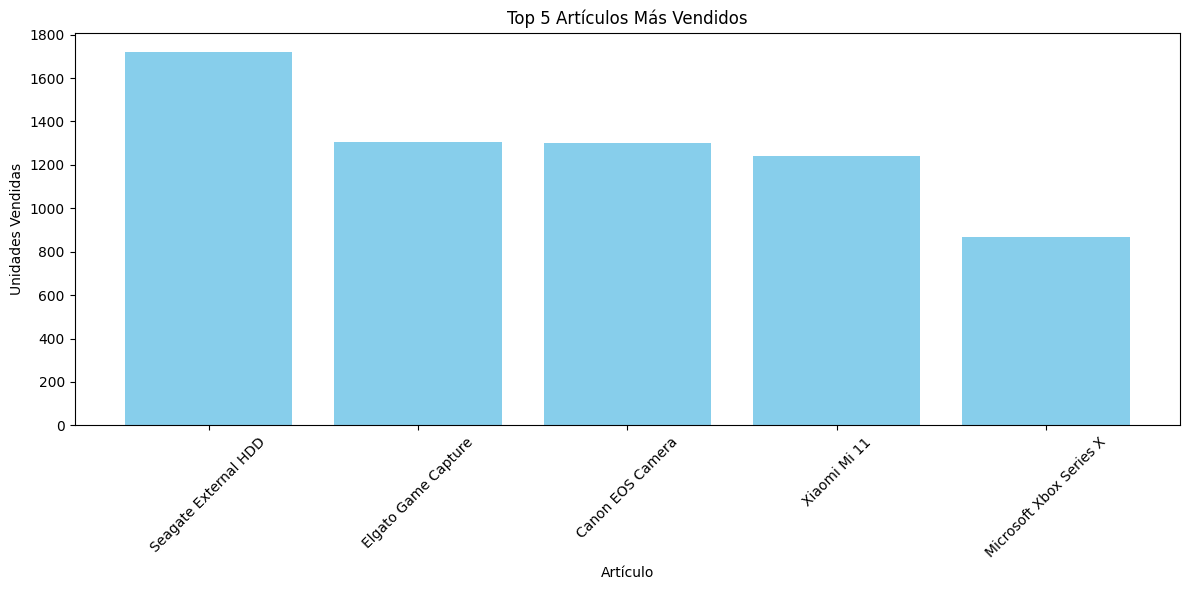

In [14]:
# Conectar a la base de datos
conexion = sqlite3.connect('../data/data/almacen.sqlite') 

  # Ejecutar la consulta y cargar los datos en un DataFrame
consulta = """SELECT
    a.idArticulo,
    a.nombreArticulo,
    SUM(v.cantidadProductos) AS unidades_vendidas,
    SUM(v.precioTotal)      AS ingresos_totales
    FROM ventas v
    JOIN articulos a ON a.idArticulo = v.idArticulo
    GROUP BY a.idArticulo, a.nombreArticulo
    ORDER BY unidades_vendidas DESC, ingresos_totales DESC, a.nombreArticulo ASC
    LIMIT 5;"""


df = pd.read_sql_query(consulta, conexion)

# Cerrar la conexión
conexion.close()

# Graficar los datos
plt.figure(figsize=(12, 6))
plt.bar(df['nombreArticulo'], df['unidades_vendidas'], color='skyblue')
plt.title('Top 5 Artículos Más Vendidos')
plt.xlabel('Artículo')
plt.ylabel('Unidades Vendidas')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()



<font color="yellow" size = "4" face = "small fonts">8. Grafique los 5 compradores que han realizado más compras.</font></center><br>

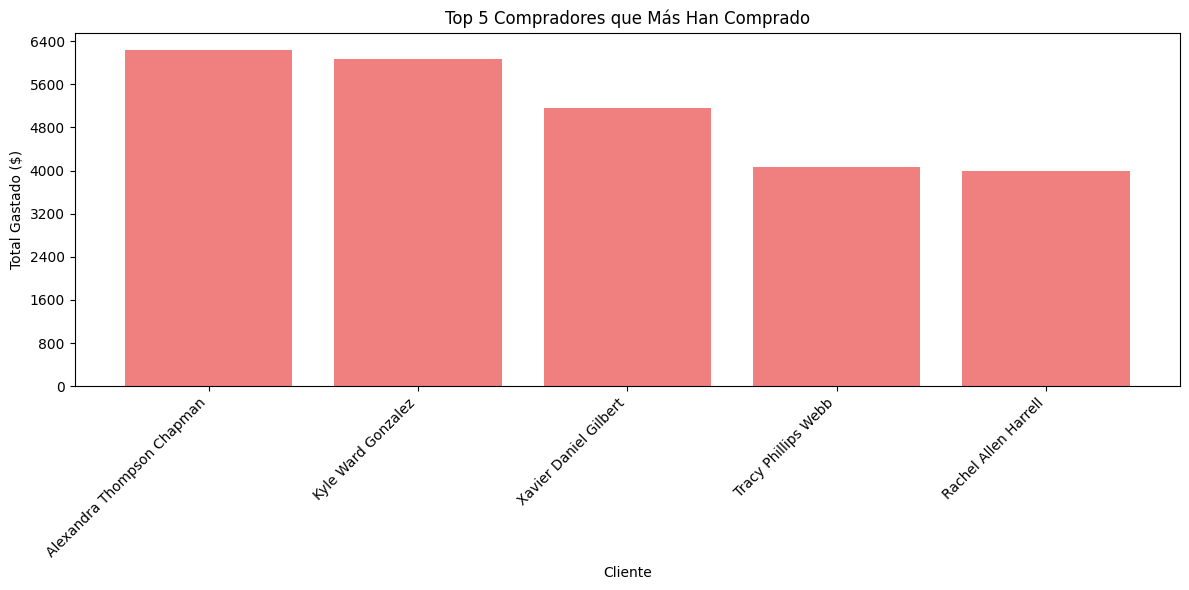

In [15]:
# Conectar a la base de datos
conexion = sqlite3.connect('../data/data/almacen.sqlite') 

# Ejecutar la consulta y cargar los datos en un DataFrame
consulta = """
SELECT
  p.numeroDocumento,
  p.nombres,
  p.primerApellido,
  p.segundoApellido,
  COUNT(*)                           AS compras_realizadas,
  SUM(v.cantidadProductos)           AS unidades_compradas,
  SUM(v.precioTotal)                 AS total_gastado
FROM ventas v
JOIN personas p ON p.numeroDocumento = v.idComprador
GROUP BY p.numeroDocumento, p.nombres, p.primerApellido, p.segundoApellido
ORDER BY unidades_compradas DESC, total_gastado DESC, p.primerApellido ASC, p.nombres ASC
LIMIT 5;
"""
df = pd.read_sql_query(consulta, conexion)


# Asegura tipos y arma el nombre completo de forma segura
# Crear nombre completo del cliente
df['cliente'] = (df['nombres'] + ' ' + df['primerApellido'] + ' ' + df['segundoApellido']).str.strip()

# Graficar
plt.figure(figsize=(12, 6))
plt.bar(df['cliente'], df['total_gastado'], color='lightcoral')
plt.title('Top 5 Compradores que Más Han Comprado')
plt.xlabel('Cliente')
plt.ylabel('Total Gastado ($)')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

# Cerrar la conexión
conexion.close()


<font color="yellow" size = "4" face = "small fonts">9. Grafique la distribución de precios de los 5 primeros artículos .</font></center><br>

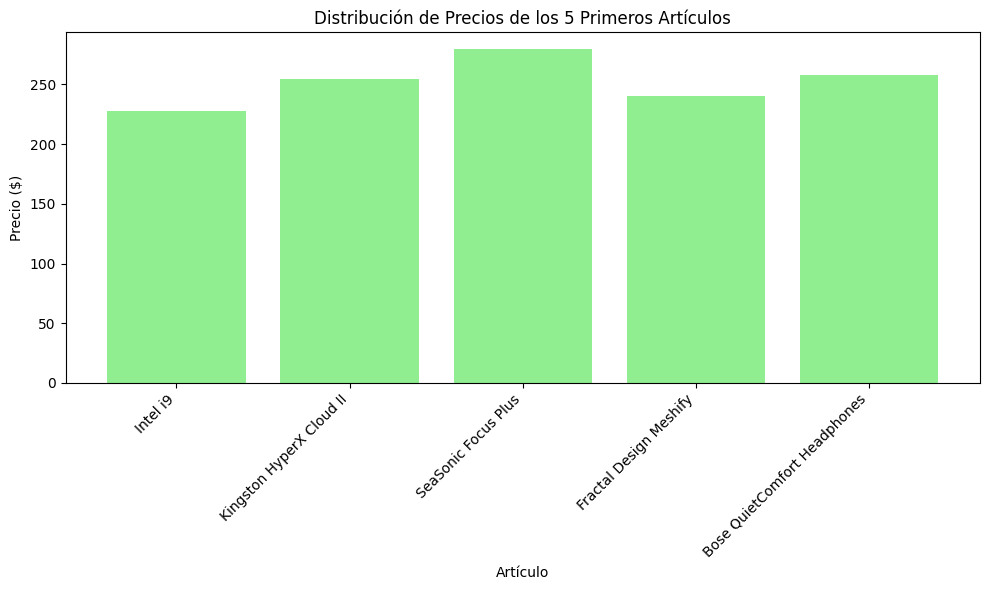

In [16]:
# Conectar a la base de datos
conexion = sqlite3.connect('../data/data/almacen.sqlite') 

# Ejecutar la consulta y cargar los datos en un DataFrame
consulta = """
SELECT
  idArticulo,
  nombreArticulo,
  precioArticulo
FROM articulos
ORDER BY idArticulo ASC
LIMIT 5;
"""
df = pd.read_sql_query(consulta, conexion)

# Graficar
plt.figure(figsize=(10, 6))
plt.bar(df['nombreArticulo'], df['precioArticulo'], color='lightgreen')
plt.title('Distribución de Precios de los 5 Primeros Artículos')
plt.xlabel('Artículo')
plt.ylabel('Precio ($)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Cerrar la conexión
conexion.close()


<font color="yellow" size = "4" face = "small fonts">10. Grafique los 5 artículos que menos se han vendido.</font></center><br>

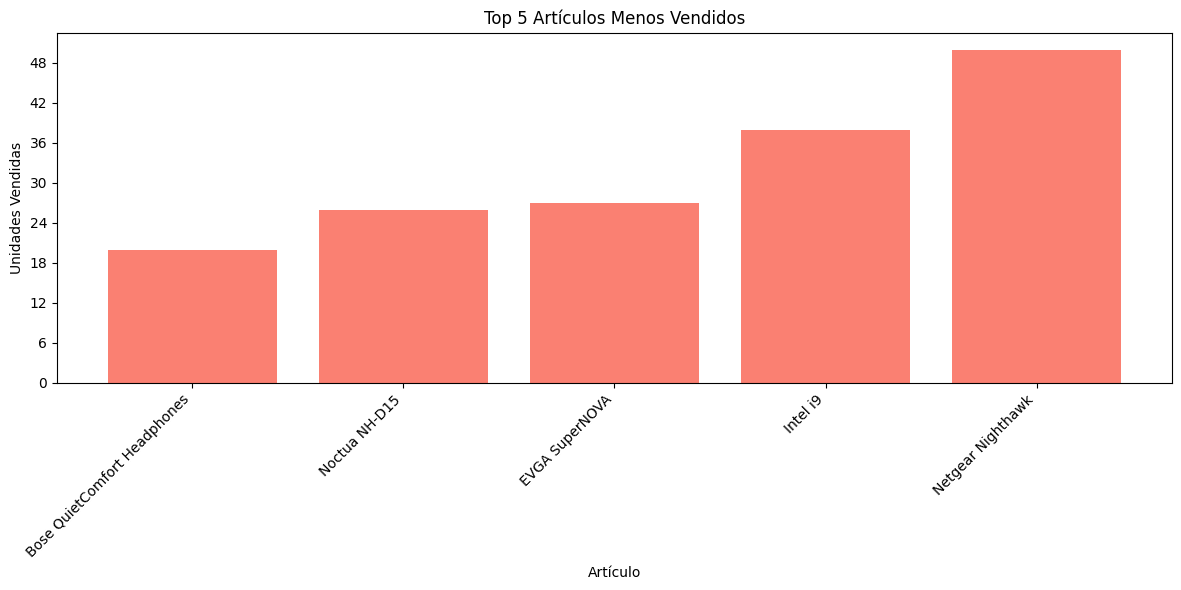

In [17]:
# Conectar a la base de datos
conexion = sqlite3.connect('../data/data/almacen.sqlite') 

# Ejecutar la consulta y cargar los datos en un DataFrame
consulta = """
SELECT
    a.idArticulo,
    a.nombreArticulo,
    COALESCE(SUM(v.cantidadProductos), 0) AS unidades_vendidas,
    COALESCE(SUM(v.precioTotal), 0) AS ingresos_totales
FROM articulos a
LEFT JOIN ventas v ON a.idArticulo = v.idArticulo
GROUP BY a.idArticulo, a.nombreArticulo
ORDER BY unidades_vendidas ASC, ingresos_totales ASC, a.nombreArticulo ASC
LIMIT 5;
"""
df = pd.read_sql_query(consulta, conexion)

# Cerrar la conexión
conexion.close()

# Graficar los datos
plt.figure(figsize=(12, 6))
plt.bar(df['nombreArticulo'], df['unidades_vendidas'], color='salmon')
plt.title('Top 5 Artículos Menos Vendidos')
plt.xlabel('Artículo')
plt.ylabel('Unidades Vendidas')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()